In [11]:
import keras as keras
import tensorflow as tf
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.layers import Bidirectional
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras.layers import Input, LSTM, Dense, Concatenate
from keras.models import Model
from itertools import permutations
import keras.backend as K
import pandas as pd
import numpy as np

In [12]:
def permutation_invariant_loss(y_true, y_pred):
    # Sort the true and predicted values along the last axis
    y_true_sorted = tf.sort(y_true, axis=-1)
    y_pred_sorted = tf.sort(y_pred, axis=-1)

    # Calculate the mean absolute error between the sorted true and predicted values
    return K.mean(K.abs(y_true_sorted - y_pred_sorted), axis=-1)
class LRHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        optimizer = self.model.optimizer
        lr = keras.backend.get_value(optimizer.lr)
        self.lr.append(lr)

In [13]:
csv_file_path = 'sinusoid_dataset.csv'
df = pd.read_csv(csv_file_path)
features = df['Feature'].apply(lambda x: np.array([float(val.strip("[]")) for val in x.split()])).values
labels = df['Label'].apply(lambda x: np.array([float(val.strip("[]")) for val in x.split(',')])).values
print(features.shape)
print(labels.shape)

(200000,)
(200000,)


In [14]:
padded_array = pad_sequences(labels, padding='post', maxlen=3)
print(padded_array.shape)
labels = np.vstack(padded_array)
features = np.vstack(features)
#scaler = MinMaxScaler()
#features = scaler.fit_transform(features)

(200000, 3)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train_categorical shape:", y_train.shape)
print("y_test_categorical shape:", y_test.shape)

X_train shape: (160000, 299)
X_test shape: (40000, 299)
y_train_categorical shape: (160000, 3)
y_test_categorical shape: (40000, 3)


2023-12-10 17:36:40.165190: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 191360000 exceeds 10% of free system memory.


In [16]:
# Define three LSTM branches
inputs = keras.Input(shape=(299,1))
# Branch 1
lstm_branch_1 = LSTM(units=64, return_sequences=True)(inputs)
flatten_1 = layers.Flatten()(lstm_branch_1)
output_branch_1 = Dense(units=1, activation='linear', name='output_branch_1')(flatten_1)

# Branch 2
lstm_branch_2 = LSTM(units=64, return_sequences=True)(lstm_branch_1)  # Pass the output of branch 1
flatten_2 = layers.Flatten()(lstm_branch_2)
output_branch_2 = Dense(units=1, activation='linear', name='output_branch_2')(flatten_2)

# Branch 3
lstm_branch_3 = LSTM(units=64, return_sequences=True)(lstm_branch_2)  # Pass the output of branch 2
flatten_3 = layers.Flatten()(lstm_branch_3)
output_branch_3 = Dense(units=1, activation='linear', name='output_branch_3')(flatten_3)

# Concatenate the outputs of the three branches
merged_output = Concatenate(axis=-1)([output_branch_1, output_branch_2, output_branch_3])

# Define the model
model = Model(inputs=inputs, outputs=merged_output)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 1)]             0         []                            
                                                                                                  
 lstm_3 (LSTM)               (None, 299, 64)              16896     ['input_2[0][0]']             
                                                                                                  
 lstm_4 (LSTM)               (None, 299, 64)              33024     ['lstm_3[0][0]']              
                                                                                                  
 lstm_5 (LSTM)               (None, 299, 64)              33024     ['lstm_4[0][0]']              
                                                                                            

In [17]:
model.compile(optimizer='adam',
              loss=permutation_invariant_loss)
overfitCallback = EarlyStopping(monitor='loss', min_delta=0, patience = 4)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, min_lr=1e-7)
lr_history = LRHistory()
model.fit(X_train_tensor, y_train_tensor, epochs=40, batch_size=256, validation_split=0.2, callbacks=[overfitCallback, lr_scheduler, lr_history])

test_loss = model.evaluate(X_test_tensor, y_test_tensor)
print(f'Test Loss: {test_loss:.4f}')

Epoch 1/40


2023-12-10 17:36:49.838952: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153088000 exceeds 10% of free system memory.


500/500 [==============================] - 58s 109ms/step - loss: 7.3645 - val_loss: 6.3420 - lr: 0.0010
Epoch 2/40
500/500 [==============================] - 53s 106ms/step - loss: 4.5125 - val_loss: 5.2158 - lr: 0.0010
Epoch 3/40
500/500 [==============================] - 51s 102ms/step - loss: 3.3613 - val_loss: 2.7732 - lr: 0.0010
Epoch 4/40
500/500 [==============================] - 54s 107ms/step - loss: 1.8208 - val_loss: 1.3119 - lr: 0.0010
Epoch 5/40
500/500 [==============================] - 55s 110ms/step - loss: 5.9945 - val_loss: 3.8212 - lr: 0.0010
Epoch 6/40
500/500 [==============================] - 52s 104ms/step - loss: 2.5769 - val_loss: 1.7997 - lr: 0.0010
Epoch 7/40
500/500 [==============================] - 52s 103ms/step - loss: 1.4668 - val_loss: 1.4118 - lr: 1.0000e-04
Epoch 8/40
500/500 [==============================] - 52s 104ms/step - loss: 1.3548 - val_loss: 1.3169 - lr: 1.0000e-04
Epoch 9/40
500/500 [==============================] - 53s 105ms/step - loss

Real Sinusoid Tests:

[[1 0 0]]
1/1 [==============================] - 0s 35ms/step
[[31.814684  86.17733   -0.1461209]]
[[10  0  0]]
1/1 [==============================] - 0s 52ms/step
[[7.8898234 2.3356285 0.0726541]]
[[19  0  0]]
1/1 [==============================] - 0s 49ms/step
[[28.551777  74.74567   -1.0897367]]
[[27  0  0]]
1/1 [==============================] - 0s 34ms/step
[[38.266987  91.39668   -0.8622265]]
[[36  0  0]]
1/1 [==============================] - 0s 38ms/step
[[ 47.121414  107.60565    -0.6885811]]
[[45  0  0]]
1/1 [==============================] - 0s 48ms/step
[[ 53.741596   117.58299     -0.46934262]]
[[54  0  0]]
1/1 [==============================] - 0s 78ms/step
[[ 57.923714  124.53717    -0.5297159]]
[[90  0  0]]
1/1 [==============================] - 0s 52ms/step
[[ 62.731575   131.8662      -0.50505507]]
Synthetic Sinusoid Tests:

[[69  0  0]]
1/1 [==============================] - 0s 34ms/step
[[ 6.887474e+01  8.094144e-02 -7.955432e-03]]
[[60 75 31]]

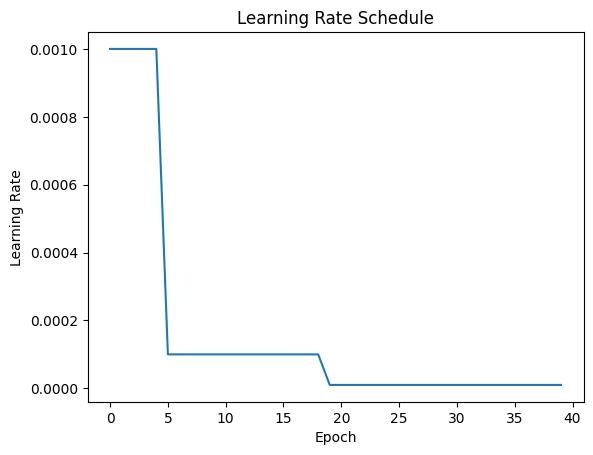

In [19]:
import matplotlib.pyplot as plt
plt.plot(lr_history.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

# Save the figure
plt.savefig('learning_rate_schedule_multiple.png', dpi=300, bbox_inches='tight')
csv_file_path = 'samplesreal.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(csv_file_path)

# Extract features and labels
features = df['Feature'].apply(lambda x: np.array([float(val.strip("[]")) for val in x.split(',')])).values
labels = [[label] for label in df['Label'].tolist()]
# Convert the string of up to 5 numbers to a NumPy array of floats

padded_array = pad_sequences(labels, padding='post', maxlen=3)
labels = np.vstack(padded_array)
features = np.vstack(features)
means = np.mean(features, axis=1, keepdims=True)
features = features - means
features = features * 50

print("Real Sinusoid Tests:\n")
for i in range(8):
  print(labels[i:i+1])
  print(model.predict(features[i:i+1]))

print("Synthetic Sinusoid Tests:\n")
for i in range(100):
  print(y_test[i:i+1])
  print(model.predict(X_test[i:i+1]))